# libraries

In [10]:
# standard
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime, date
from collections import defaultdict, Counter
import json
from concurrent.futures import ThreadPoolExecutor, as_completed

# graphs
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# load data

In [11]:
market_cap_df = pd.read_csv('../data/market_cap.csv').T
closing_prices_df = pd.read_csv('../data/closing_prices.csv').T
relative_changes_df = pd.read_csv('../data/relative_pricechanges.csv')
# rename columns
market_cap_df.columns = market_cap_df.loc['Quarter']
closing_prices_df.columns = closing_prices_df.loc['Unnamed: 0']
# Drop the 'Quarter' row
market_cap_df = market_cap_df.drop('Quarter').sort_index()
closing_prices_df = closing_prices_df.drop('Unnamed: 0').sort_index()

relative_changes_df.index = relative_changes_df['Unnamed: 0']
relative_changes_df = relative_changes_df.drop('Unnamed: 0', axis=1).sort_index()

# add market_cap to closing prices df
closing_prices_df['market_cap'] = relative_changes_df['market_cap']

# size effect

In [12]:
def relative_prices_daily(data, interval_size):
    # Step 1: Calculate Daily Relative Price Changes
    df = data.drop('market_cap', axis=1).iloc[:,::-1].ffill().pct_change(periods=-1, axis = 1).iloc[:,::-1]

    # Step 2: Identify Outliers
    std_dev = df.std()
    mean = df.mean()
    cutoff = std_dev * interval_size

    lower_bound = mean - cutoff
    upper_bound = mean + cutoff

    # Step 3: Interpolate Outliers
    for column in df.columns:
        outliers = (df[column] < lower_bound[column]) | (df[column] > upper_bound[column])
        df[column][outliers] = np.nan
        # Ensure the data type is numeric for interpolation
        df[column] = pd.to_numeric(df[column], errors='coerce')
        df[column].interpolate(method='linear', inplace=True)

    # Avoid DataFrame fragmentation by creating a new DataFrame
    df = pd.concat([df, data[['market_cap']]], axis=1)

    return df 

relative_changes_daily_df = relative_prices_daily(closing_prices_df, 3)

/tmp/ipykernel_757/2618254613.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_data = pd.concat([plot_data, plot_df])


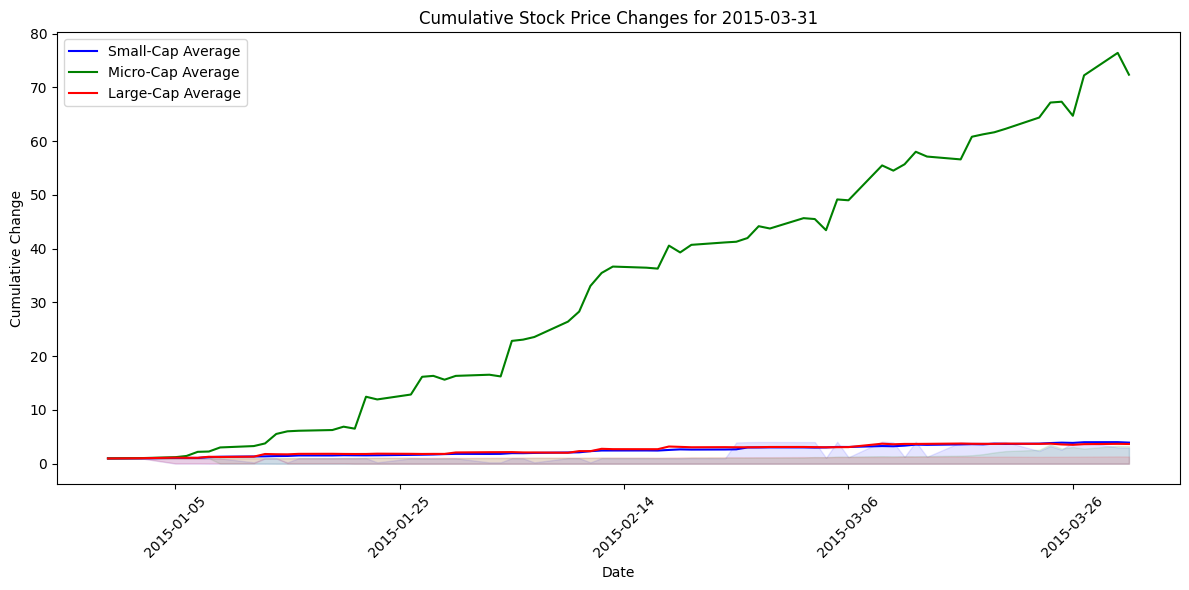

/tmp/ipykernel_757/2618254613.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_data = pd.concat([plot_data, plot_df])


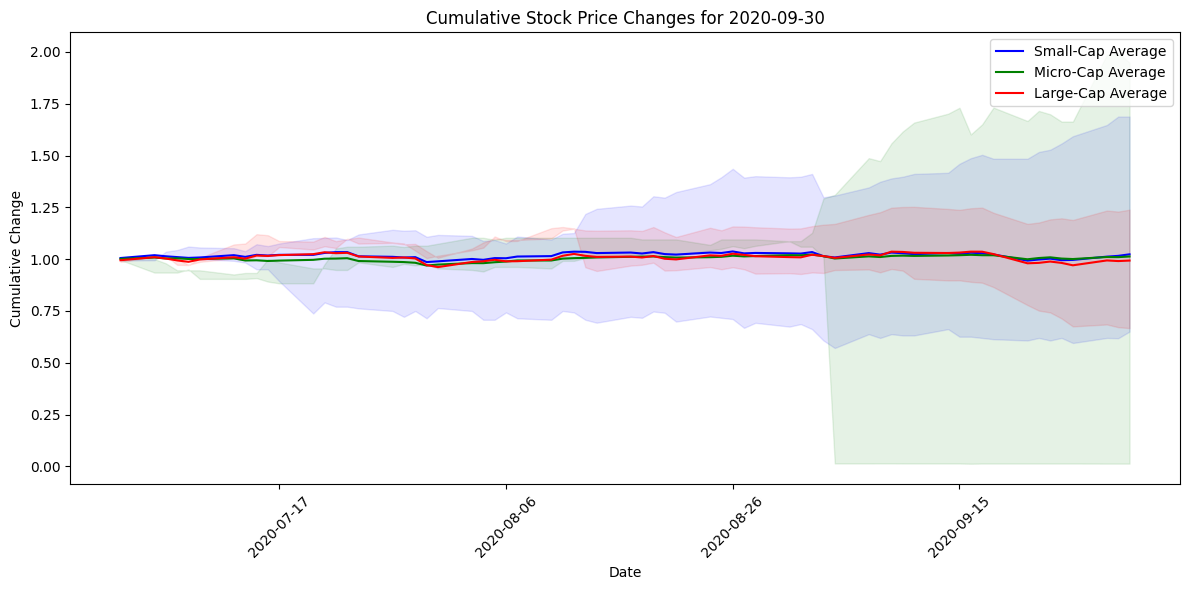

/tmp/ipykernel_757/2618254613.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_data = pd.concat([plot_data, plot_df])


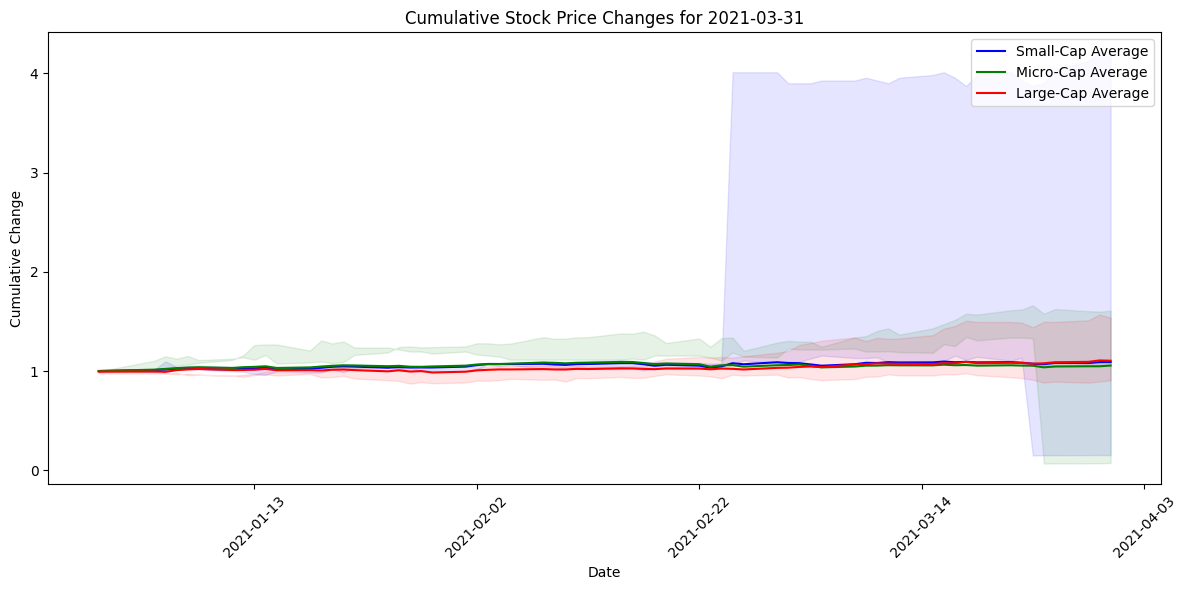

/tmp/ipykernel_757/2618254613.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_data = pd.concat([plot_data, plot_df])


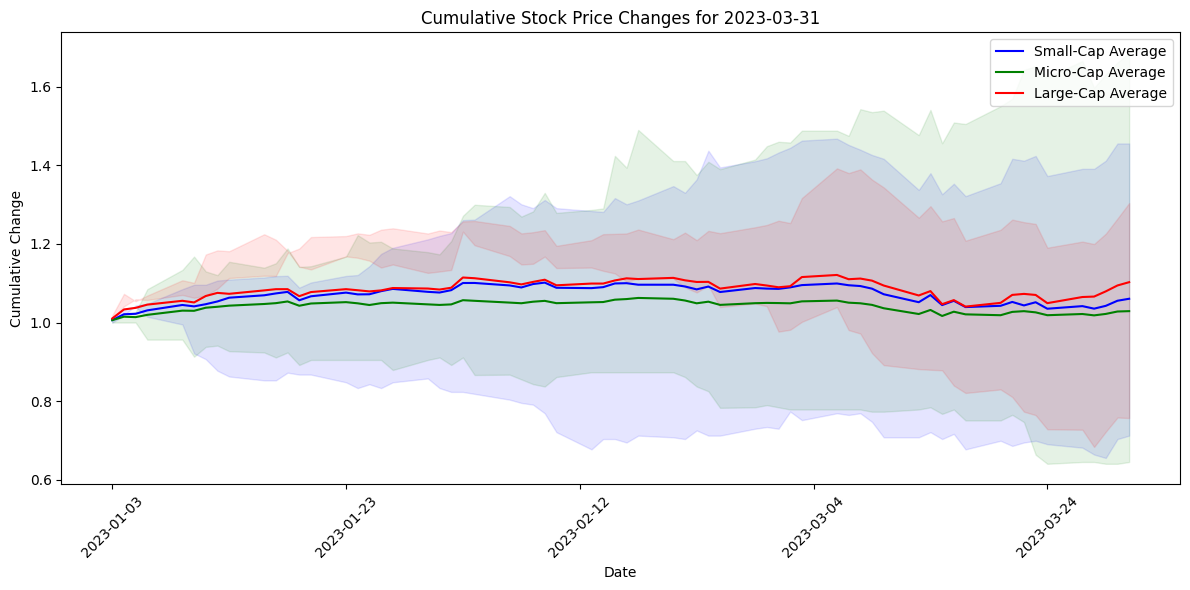

/tmp/ipykernel_757/2618254613.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_data = pd.concat([plot_data, plot_df])


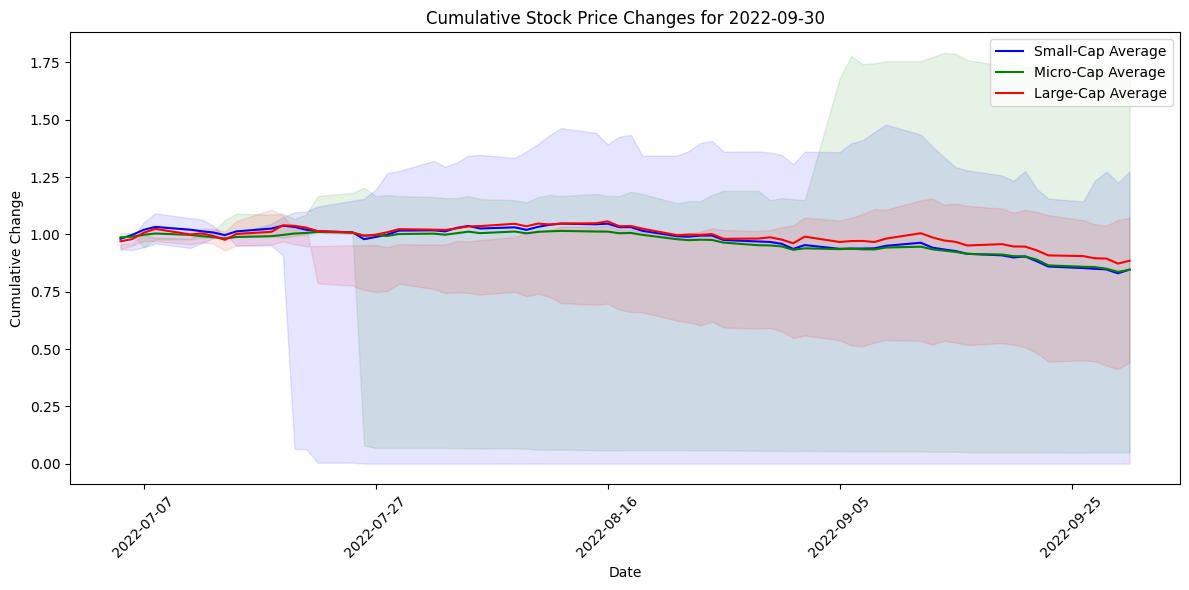

In [13]:
quarters = ['2015-03-31', '2020-09-30', '2021-03-31', '2023-03-31', '2022-09-30']
data = relative_changes_daily_df.copy()

for quarter in quarters:
        # Find the index of the quarter and get the indices of the last three months
    quarter_index = data.columns.get_loc(quarter)
    start_index = max(0, quarter_index - 63)  # Ensure it doesn't go below 0

        # Slicing the DataFrame for the last three months
    sliced_df = data.iloc[:, np.r_[start_index:quarter_index + 1, -1]]
    plot_data = pd.DataFrame(columns=sliced_df.columns)

    for market_cap_category in ['Small-Cap', 'Micro-Cap', 'Large-Cap']:
            category_df = sliced_df[sliced_df['market_cap'] == market_cap_category]

            # Calculate average, min, and max price change
            avg_company = category_df.drop(columns=['market_cap']).mean(axis=0)
            total_returns = (category_df.iloc[:,:-1] + 1).prod(axis = 1) - 1
            max_company = category_df.loc[total_returns.idxmax(),][:-1]
            min_company = category_df.loc[total_returns.idxmin(),][:-1]

            plot_df = pd.DataFrame(columns=sliced_df.columns)
            plot_df.loc[f"{market_cap_category}_avg"] = avg_company
            plot_df.loc[f"{total_returns.idxmax()}"] = max_company
            plot_df.loc[f"{total_returns.idxmin()}"] = min_company
            plot_df.loc[:,'market_cap'] = market_cap_category

            plot_data = pd.concat([plot_data, plot_df])
    
    linegraph_df = plot_data.T

    # Convert the daily changes to growth factors (1 + daily change)
    growth_factors = 1 + linegraph_df.iloc[:-1,:]

    # Calculate the cumulative product along the time axis (axis=0 for rows)
    cumulative_growth = growth_factors.cumprod()

    # Convert 'Unnamed: 0' to matplotlib date format
    cumulative_growth_reset = cumulative_growth.reset_index()
    cumulative_growth_reset['Unnamed: 0'] = pd.to_datetime(cumulative_growth_reset['Unnamed: 0'])
    x_axis = mdates.date2num(cumulative_growth_reset['Unnamed: 0'])

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plotting Small-Cap with boundaries

    # Convert to numeric and handle NaN values
    plt.fill_between(
        x_axis,
        pd.to_numeric(cumulative_growth_reset.iloc[:, 2], errors='coerce').ffill(),
        pd.to_numeric(cumulative_growth_reset.iloc[:, 3], errors='coerce').ffill(),
        color = 'blue',
        alpha = 0.1
    )
    plt.plot(x_axis, cumulative_growth_reset['Small-Cap_avg'], label='Small-Cap Average', color='blue')

    # Plotting Micro-Cap with boundaries
    plt.fill_between(
        x_axis,
        pd.to_numeric(cumulative_growth_reset.iloc[:, 5], errors='coerce').ffill(),
        pd.to_numeric(cumulative_growth_reset.iloc[:, 6], errors='coerce').ffill(),
        color = 'green',
        alpha = 0.1
    )
    plt.plot(x_axis, cumulative_growth_reset['Micro-Cap_avg'], label='Micro-Cap Average', color='green')

    # Plotting Large-Cap with boundaries
    plt.fill_between(
        x_axis,
        pd.to_numeric(cumulative_growth_reset.iloc[:, 8], errors='coerce').ffill(),
        pd.to_numeric(cumulative_growth_reset.iloc[:, 9], errors='coerce').ffill(),
        color = 'red',
        alpha = 0.1
    )
    plt.plot(x_axis, cumulative_growth_reset['Large-Cap_avg'], label='Large-Cap Average', color='red')

    title_str = f'Cumulative Stock Price Changes for {quarter}'

    plt.title(title_str)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Change')
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"../graphs/{title_str}.png")
    plt.show()

# Test Area